In [ ]:
from pathlib import Path
import os
from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.tracker import SaveModelCallback
from drone_detector.engines.fastai.data import *
from drone_detector.metrics import JaccardCoeffMulti
import wandb


# Model training

Specify which patch locations are used for validation.

In [ ]:
outpath = Path('../data/processed/train')
patches = sorted(os.listdir(outpath/'1984'/'raster_tiles'))
val_files = patches[int(len(patches)*.75):]
fnames = [Path(outpath/year/'raster_tiles'/f) for year in ['1965', '1984'] 
          for f in os.listdir(outpath/year/'raster_tiles')]

Locations are the same for both years in order to prevent data leakage.

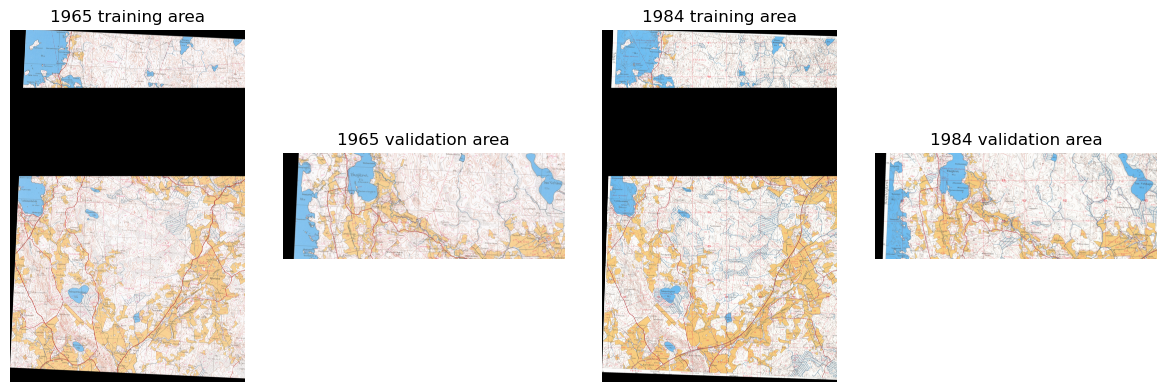

In [ ]:
import rasterio as rio
import rasterio.merge as rio_merge
import rasterio.plot as rioplot

rasters = []

fig, ax = plt.subplots(1,4, figsize=(12,4))
for a in ax: a.axis('off')
rasters = []
for f in [s for s in patches if s not in val_files]:
    src = rio.open(outpath/'1965/raster_tiles'/f)
    rasters.append(src)

mos, tfm = rio_merge.merge(rasters)
ax[0].imshow(np.moveaxis(mos,0,2))
ax[0].set_title('1965 training area')

rasters = []
for f in val_files:
    src = rio.open(outpath/'1965/raster_tiles'/f)
    rasters.append(src)

mos, tfm = rio_merge.merge(rasters)
ax[1].imshow(np.moveaxis(mos,0,2))
ax[1].set_title('1965 validation area')

rasters = []
for f in [s for s in patches if s not in val_files]:
    src = rio.open(outpath/'1984/raster_tiles'/f)
    rasters.append(src)

mos, tfm = rio_merge.merge(rasters)
ax[2].imshow(np.moveaxis(mos,0,2))
ax[2].set_title('1984 training area')

rasters = []
for f in val_files:
    src = rio.open(outpath/'1984/raster_tiles'/f)
    rasters.append(src)

mos, tfm = rio_merge.merge(rasters)
ax[3].imshow(np.moveaxis(mos,0,2))
ax[3].set_title('1984 validation area')
plt.tight_layout()
plt.show()

We need to slighly modify fastai's `SegmentationDataLoaders` so that we can specify the tiles to use as validation data during training.

In [ ]:
class SegmentationDataLoadersFix(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for segmentation problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, codes=None, item_tfms=None, batch_tfms=None, 
                        img_cls=PILImage,val_fnames=None,**kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(ImageBlock(img_cls), MaskBlock(codes=codes)),
                           splitter=FuncSplitter(lambda o: o.name in val_files) if val_fnames else RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

The models are trained using [fastai](https://docs.fast.ai) library. During training, the images are randomly flipped horizontally, brightness and contrast and saturation are randomly adjusted, images are rotated randomly (maximum rotation 5 degrees) and random areas are erased from the images.

In [ ]:
dls = SegmentationDataLoadersFix.from_label_func('../data/', bs=8,
                                              codes = ['Background',
                                                       'Fields',
                                                       'Mires',
                                                       'Roads',
                                                       'Watercourses',
                                                       'Water bodies'],
                                              fnames=fnames,
                                              label_func=(partial(label_from_different_folder,
                                                                 original_folder='raster_tiles',
                                                                 new_folder='mask_tiles')),
                                              batch_tfms = [
                                                  *aug_transforms(max_rotate=5., 
                                                                  max_warp=0., 
                                                                  max_zoom=1,
                                                                  pad_mode='zeros',
                                                                  xtra_tfms=[
                                                  Saturation(max_lighting=0.3)]),
                                                  RandomErasing(max_count=2),
                                                  Normalize.from_stats(*imagenet_stats)
                                              ],
                                               num_workers=0, val_fnames=val_files)

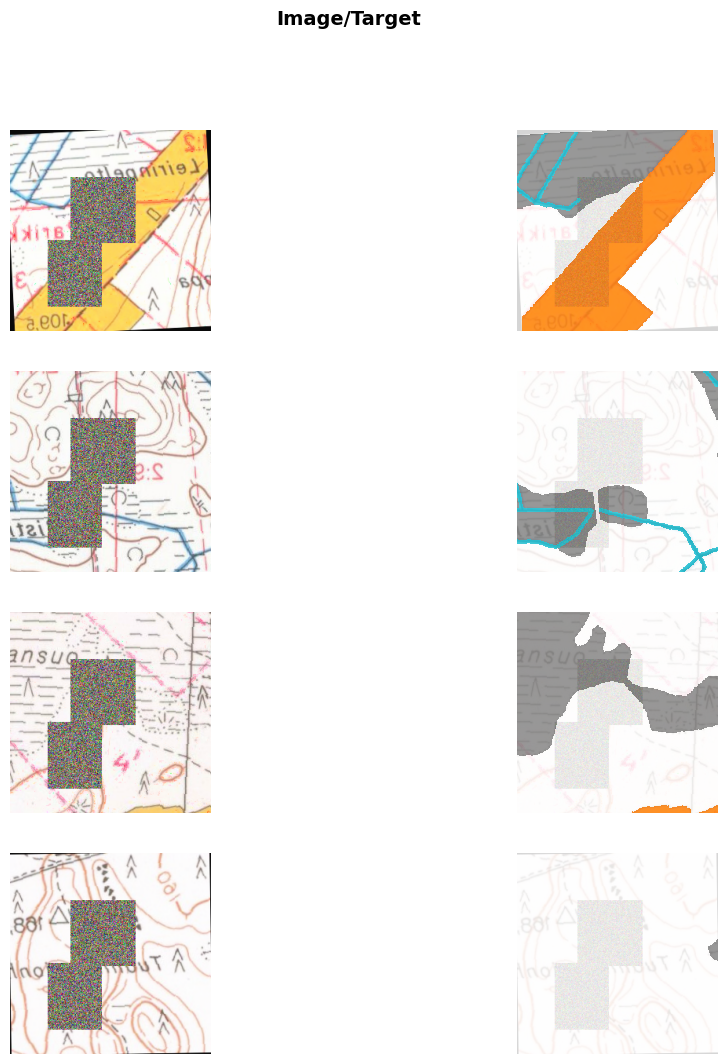

In [ ]:
from matplotlib import colors
cmap = colors.ListedColormap(['white', 'tab:orange', 'tab:grey', 'tab:red', 'tab:cyan', 'tab:blue'])
bounds=[0,1,2,3,4,5]

dls.show_batch(max_n=8, cmap=cmap, alpha=0.8, vmin=0, vmax=5)

We used U-Net  [(Roenneberger, Fischer and Brox, 2015)](https://arxiv.org/abs/1505.04597) architecture with ResNet152 as the encoder and Focal Loss as the loss function. The model evaluation metrics are Dice and Jaccard coefficients for multiclass tasks. Dice coefficient is twice the area of overlap in pixels divided by the total number of pixels in the images, while Jaccard coefficient is the area of intersection divided by the area of union. Both metrics are computed for each class separately, and then averaged, excluding background class. 

In [ ]:
learn = unet_learner(dls, arch=resnet152, pretrained=True, n_in=3, n_out=6, blur=False, self_attention=False,
                     metrics=[DiceMulti(), JaccardCoeffMulti()], loss_func=FocalLossFlat(axis=1)).to_fp16()

SuggestedLRs(valley=0.00013182566908653826)

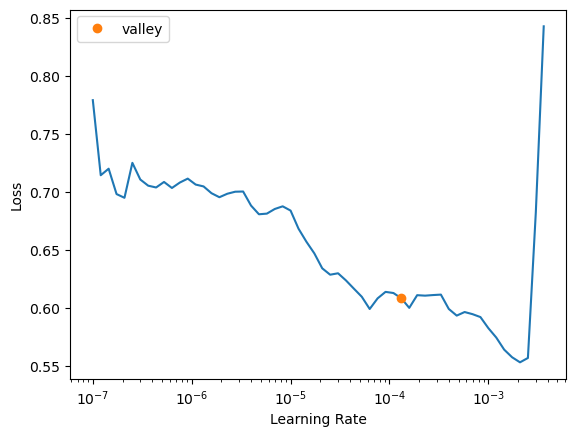

In [ ]:
learn.lr_find()

Track the training with wandb.

In [ ]:
#| output: false
wandb.init(project='historical-maps')

wandb: Currently logged in as: mayrajeo. Use `wandb login --relogin` to force relogin


As the task is fairly simple, we trained the model for 1 frozen epochs (only the classification layer and decoder), and 10 unfrozen epochs (all layers unfrozen).

epoch,train_loss,valid_loss,dice_multi,jaccard_coeff_multi,time
0,0.279371,0.095017,0.614953,0.479049,00:41


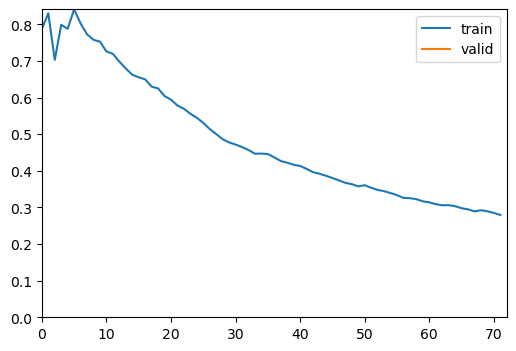

epoch,train_loss,valid_loss,dice_multi,jaccard_coeff_multi,time
0,0.108342,0.054258,0.819533,0.679720,00:44
1,0.096652,0.045088,0.865541,0.747566,00:44
2,0.102842,0.040958,0.877481,0.766594,00:44
3,0.093429,0.038590,0.872097,0.760775,00:44
4,0.079442,0.041260,0.848776,0.728254,00:44
5,0.068051,0.037962,0.891336,0.789572,00:44
6,0.064024,0.029071,0.902043,0.807192,00:44
7,0.056828,0.030130,0.902029,0.806753,00:44
8,0.051534,0.026503,0.906512,0.814374,00:44
9,0.050650,0.026493,0.907033,0.815146,00:44


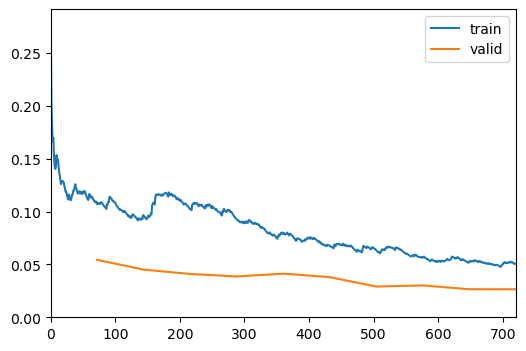

In [ ]:
learn.fine_tune(10, freeze_epochs=1, base_lr=1e-4, cbs=[ShowGraphCallback, WandbCallback(log_preds_every_epoch=True)])

In [ ]:
#|output: false
learn.to_fp32()
wandb.finish()

dice_multi,▁▆▇▇▇▇█████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
jaccard_coeff_multi,▁▅▇▇▇▆▇████
lr_0,▁▃▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▃▆█▂▂▂▂▃▃▄▄▄▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
lr_2,▁▃▆█▂▂▂▂▃▃▄▄▄▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▆▃▁██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇▇████
mom_1,█▆▃▁██▇▆▅▄▃▂▂▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇▇████


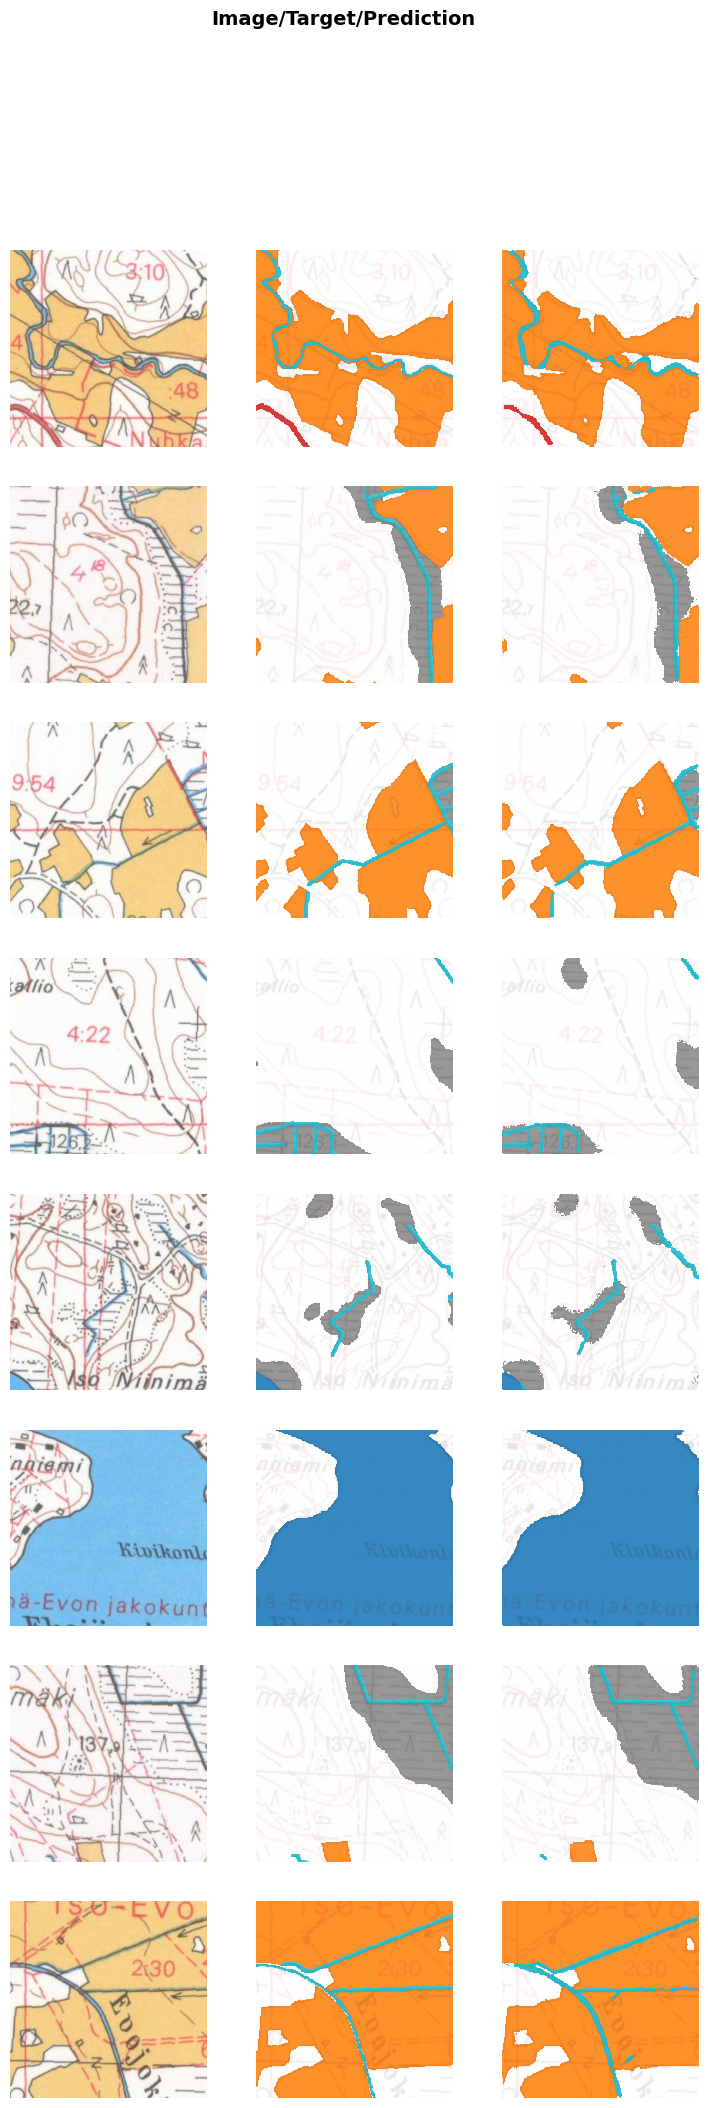

In [ ]:
learn.show_results(max_n=8, cmap=cmap, alpha=0.8, vmin=0, vmax=5)

In [ ]:
learn.validate()

(#3) [0.026490652933716774,0.9070572012651771,0.815188080909637]

In [ ]:
learn.path = Path('../models')
learn.export(fname='resnet152_focal_final.pkl')

# Test with remaining labeled data

## Example result patches

In [ ]:
learn = load_learner('../models/resnet152_focal_final.pkl', cpu=False)

In [ ]:
valid_im_path = Path('../data/processed/val/')
val_images = [Path(valid_im_path/year/'raster_tiles'/f) for year in ['1965', '1984'] 
          for f in os.listdir(valid_im_path/year/'raster_tiles')]

In [ ]:
testdl = learn.dls.test_dl(val_images, with_labels=True, bs=32, shuffle=True)

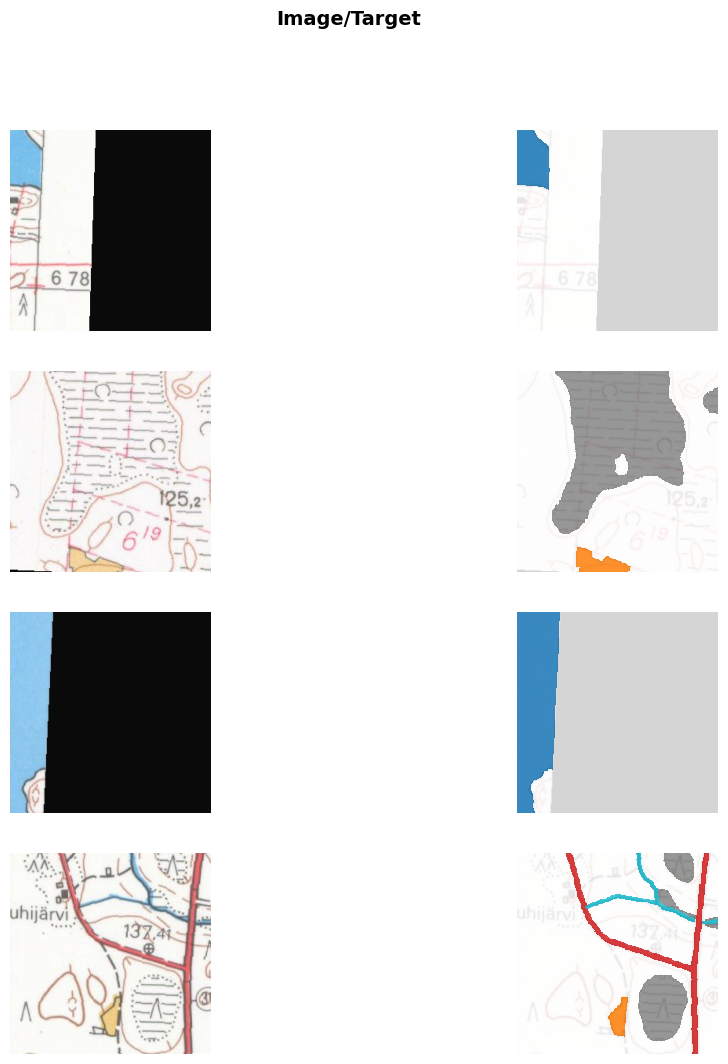

In [ ]:
testdl.show_batch(max_n=8, cmap=cmap, alpha=0.8, vmin=0, vmax=5)

Check the loss, dice score and jaccard score for this dataset.

In [ ]:
learn.validate(dl=testdl)

(#3) [0.0324639268219471,0.9150828108979138,0.8291330712382363]

And then some example results.

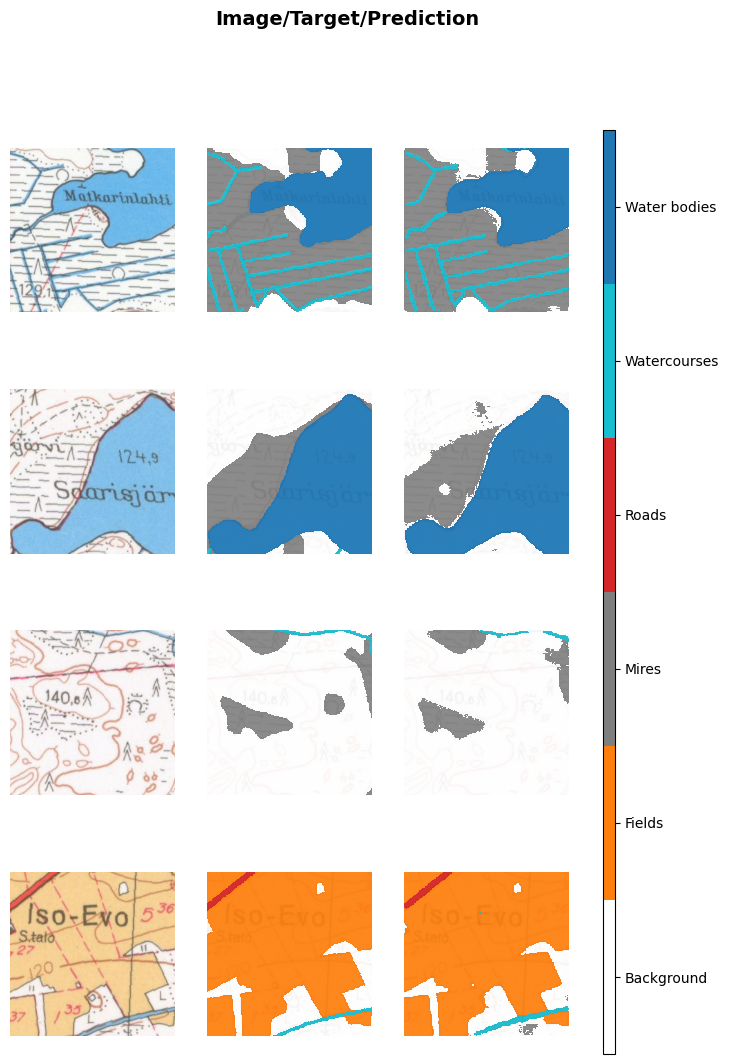

In [ ]:
learn.show_results(dl=testdl, max_n=4, cmap=cmap, alpha=.9)
f = plt.gcf()
norm = colors.Normalize(vmin=0,vmax=6)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=f.axes, ticks=np.arange(0.5,6.5), aspect=75)
cbar.ax.set_yticklabels(['Background', 'Fields', 'Mires', 'Roads', 'Watercourses', 'Water bodies'])
plt.savefig('../data/figures/example_test_predictions.jpg', dpi=300, bbox_inches='tight')

## Classwise metrics

These results are before any morphological post-processings, and before merging the results into large tiles.

In [ ]:
def dice(targs, preds, cls_id):
    inter = (torch.where(targs==cls_id, 1, 0)*torch.where(preds==cls_id, 1, 0)).float().sum()
    union = (torch.where(targs==cls_id, 1, 0)+torch.where(preds==cls_id, 1, 0)).float().sum()
    return 2 * inter/union if union > 0 else None

def jaccard(targs, preds, cls_id):
    inter = (torch.where(targs==cls_id, 1, 0)*torch.where(preds==cls_id, 1, 0)).float().sum()
    union = (torch.where(targs==cls_id, 1, 0)+torch.where(preds==cls_id, 1, 0)).float().sum()
    return inter/(union-inter) if union > 0 else None

### Validation set

In [ ]:
_, targs, preds = learn.get_preds(with_decoded=True)

#### Fields

Dice score for fields:

In [ ]:
dice(targs, preds, 1)

TensorBase(0.9707)

Jaccard score for fields:

In [ ]:
jaccard(targs, preds, 1)

TensorBase(0.9431)

#### Mires

Dice score for mires:

In [ ]:
dice(targs, preds, 2)

TensorBase(0.8787)

Jaccard score for mires:

In [ ]:
jaccard(targs, preds, 2)

TensorBase(0.7836)

#### Roads

Dice score for roads:

In [ ]:
dice(targs, preds, 3)

TensorBase(0.8595)

Jaccard score for roads:

In [ ]:
jaccard(targs, preds, 3)

TensorBase(0.7536)

#### Watercourses

Dice score for watercourses:

In [ ]:
dice(targs, preds, 4)

TensorBase(0.7633)

Jaccard score for watercourses:

In [ ]:
jaccard(targs, preds, 4)

TensorBase(0.6172)

#### Water bodies

Dice score for water bodies:

In [ ]:
dice(targs, preds, 5)

TensorBase(0.9891)

Jaccard score for water bodies:

In [ ]:
jaccard(targs, preds, 5)

TensorBase(0.9784)

### Test set

In [ ]:
_, targs, preds = learn.get_preds(dl=testdl, with_decoded=True)

#### Fields

Dice score for fields:

In [ ]:
dice(targs, preds, 1)

TensorBase(0.9665)

Jaccard score for fields:

In [ ]:
jaccard(targs, preds, 1)

TensorBase(0.9352)

#### Mires

Dice score for mires:

In [ ]:
dice(targs, preds, 2)

TensorBase(0.8927)

Jaccard score for mires:

In [ ]:
jaccard(targs, preds, 2)

TensorBase(0.8063)

#### Roads

Dice score for roads:

In [ ]:
dice(targs, preds, 3)

TensorBase(0.8723)

Jaccard score for roads:

In [ ]:
jaccard(targs, preds, 3)

TensorBase(0.7735)

#### Watercourses

Dice score for watercourses:

In [ ]:
dice(targs, preds, 4)

TensorBase(0.7960)

Jaccard score for watercourses:

In [ ]:
jaccard(targs, preds, 4)

TensorBase(0.6611)

#### Water bodies

Dice score for water bodies:

In [ ]:
dice(targs, preds, 5)

TensorBase(0.9846)

Jaccard score for water bodies:

In [ ]:
jaccard(targs, preds, 5)

TensorBase(0.9696)